# Optimise Prime

## Import libraries and dependencies


In [38]:
#import hvplot.pandas
import panel as pn
pn.extension('plotly')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


import optimiseprime.data_prep as dp
import optimiseprime.data_analysis as da
import optimiseprime.forecast as forecast
from optimiseprime.MCForecastTools import MCSimulation


import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
qs.extend_pandas()

%matplotlib inline


## Request user for portfolio details, and fetch price data from yfinance Yahoo! Finance API

In [ ]:
portfolio_choice = 0

while portfolio_choice not in [1, 2]:
    try:
        portfolio_choice = int(input(         
            "To analyse an existing portfolio, type 1\n"
            "To analyse a hypothetical portfolio, type 2\n"
        )
                              )
    # Print error message if type(portfolio_choice) != int                        
    except ValueError:
        print('Error: Invalid response.\n')
        
    # Print error message if portfolio choice not 1 or 2
    if portfolio_choice not in [1, 2]:
        print('Error: Invalid response.\n')

# Get portfolio data from user depending on choice:

ticker_list = []

while len(ticker_list) == 0:
    if portfolio_choice == 1:
        existing_portfolio = dp.get_existing_portfolio()
        
        # Create a list of only the tickers
        ticker_list = []
        for key, value in existing_portfolio.items():
            ticker_list.append(key)
        
    elif portfolio_choice == 2:
        ticker_list = dp.get_hypothetical_portfolio()
        # Request investment amount from user
        portfolio_value = dp.get_investment_amt()
        
    if len(ticker_list) == 0:
        print("You have not entered any tickers.")  

In [ ]:
# Fetch data from yfinance for each ticker, and create pandas dataframe
portfolio_df = dp.get_ticker_data(ticker_list)
portfolio_df.dropna(inplace = True)
display(portfolio_df)


In [ ]:
# Keep only tickers in ticker_list for which data is available
ticker_list = [ticker for ticker in list(portfolio_df.columns.levels[0])]
value_list = []
weight_list = []

# Print portfolio data for visual confirmation
if portfolio_choice == 1:    
    # Calculate portfolio value of each cryptocurrency held
    for ticker in existing_portfolio:
        existing_portfolio[ticker].append(
            {'value': portfolio_df[ticker].iloc[-1, 3] * existing_portfolio[ticker][0]['units']})
    print(f"--------------------------")                      
    print(f"Existing Portfolio:")
    portfolio_value = 0
    for ticker, units in existing_portfolio.items():
        value = existing_portfolio[ticker][1]['value']
        print(f"Value of {existing_portfolio[ticker][0]['units']} {ticker}: ${value:.2f}")
        portfolio_value += value
       
    # Add weights for each crypto to existing_portfolio
    for ticker, units in existing_portfolio.items():
        weight = existing_portfolio[ticker][1]['value'] / portfolio_value
        existing_portfolio[ticker][1]['weight'] = weight

    print(f"\nTotal portfolio value: ${portfolio_value:.2f}\n")       


    #find current weights
    for ticker, units in existing_portfolio.items():
        weight_list.append(existing_portfolio[ticker][1]['weight'])
        value_list.append(existing_portfolio[ticker][1]['value'])
    pie_df = px.data.tips()
    px.pie(pie_df, values=value_list, names=ticker_list,   title="Distribution of existing portfolio", color_discrete_sequence=px.colors.sequential.RdBu).show()

elif portfolio_choice == 2:
    print(
        f"--------------------------\n"
        f"Hypothetical Portfolio:\n"
        f"{[ticker.replace('-USD', '') for ticker in ticker_list]}\n"                   
        f"Investment amount:\n"
        f"${portfolio_value:.2f}\n")
print(
    f"NOTE:\n"
    f"To achieve a fair comparison of risk-reward ratios, historical price data will be retrieved from earliest date for which ALL cryptocurrencies specified are available.\n"
    f"While this ensures fair comparison of risk-reward metrics, it may compromise accuracy of these metrics if the sample sizes of historical price data are reduced.\n"
    f"Earliest date for which price data is available for all cryptocurrencies in your portfolio: {dt.datetime.date(portfolio_df.index[0])}"
)
print(f"--------------------------")




## Visualisation of Portfolio Historical Returns

In [21]:
#weights of original
if portfolio_choice == 1:
    weight_og = pd.DataFrame([weight_list], columns = ticker_list)



In [22]:
daily_returns = portfolio_df.filter(like = "daily_return")
dr = []
for ticker in ticker_list:
    dr.append(ticker)
daily_returns.columns = dr

daily_returns.head()

,BTC-USD,ETH-USD
Date,,
2019-01-19,0.019336,0.028996
2019-01-20,-0.034210,-0.040509
2019-01-21,-0.006937,-0.019393
2019-01-22,0.007982,0.013569
2019-01-23,-0.005397,-0.010905


In [23]:
#FIRST PAGE 
price_chart = close.hvplot.line()
price_chart = price_chart.opts(title='historical data of tickers with 1d intervals', xaxis=None)
daily_returns_plot = px.line(price_chart, daily_returns, x = daily_returns.index, y = daily_returns.columns, title = "Daily returns (gains or losses)")
first_page = pn.Column(title, welcome_text, daily_returns.head(), daily_returns_plot)

#SECOND PAGE
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumul_plot = px.line(cumulative_returns, x = cumulative_returns.index, y = cumulative_returns.columns, title = "Cumulative Returns")

second_page = pn.Column("cumulative returns overtime", cumulative_returns.head(), cumul_plot)

#THIRD PAGE
boxplot = px.box(daily_returns, y=daily_returns.columns, title = 'Visual Representation of Risk')
third_page = pn.Column("Risk visualised on a box plot", boxplot)

#Fourth Page
if portfolio_choice == 1:
    portfolio_og = daily_returns.dot(weight_og.iloc[0,:])
    portfolio_og = pd.DataFrame(portfolio_og, columns = ['My Portfolio'])

    cumulative_returns_port = (1 + portfolio_og).cumprod() - 1
    daily_returns_port = px.line(portfolio_og, x = portfolio_og.index, y = portfolio_og.columns, title = "Daily returns of my portfolio")
    cumul_plot_port = px.line(cumulative_returns_port, x = cumulative_returns_port.index, y = cumulative_returns_port.columns, title = "Cumulative Returns of my portfolio")

    fourth_page = pn.Column("Portfolio Analysis", portfolio_og.head(), daily_returns_port, cumul_plot_port)

if portfolio_choice == 1:
    daily_dashboard = pn.Tabs(
        ("Daily Returns of tickers", first_page),
        ("Cumulative Returns of tickers", second_page),
        ("Risk of tickers", third_page),
        ("Historical Returns of my portfolio", fourth_page)
    )
else:
    daily_dashboard = pn.Tabs(
    ("Daily Returns of tickers", first_page),
    ("Cumulative Returns of tickers", second_page),
    ("Risk of tickers", third_page)
)


daily_dashboard.show()

Launching server at http://localhost:54628


---

# Analysis: Risk-Reward Ratios and Recommended Weights

### Calculate ratios:
* Sharpe ratio
* Sortino ratio
* Adjusted sortino ratio
* Gain to Pain ratio

In [24]:
# Calculate each of the following risk-reward ratio types
sharpe = da.calculate_sharpe_ratio(ticker_list, portfolio_df)
sortino =  da.calculate_sortino_ratio(ticker_list, portfolio_df)
adjusted_sortino = da.calculate_adjusted_sortino(ticker_list, portfolio_df)
gain_pain_ratio = da.calculate_gain_pain_ratio(ticker_list, portfolio_df)


# Store all ratios into a dict
ratios_df = pd.DataFrame(
    {
    'sharpe': sharpe,
    'sortino': sortino,
    'adj_sortino': adjusted_sortino,
    'gain_pain': gain_pain_ratio,
    }
)
#display(ratios_df)

# Calculate proportion scores for each risk-reward metric
weights = da.calculate_weights(ratios_df)

# If user has selected to analyse an existing portfolio, add user's portfolio weights as well.
if portfolio_choice == 1 :
    weight_og = weight_og.transpose()
    weights = weights.merge(weight_og, left_index=True, right_index=True)
weights=weights.rename(columns = {0:'user_portfolio'})


display(ratios_df)



,sharpe,sortino,adj_sortino,gain_pain
BTC-USD,1.4926,2.2262,1.5742,0.2644
ETH-USD,1.6592,2.4551,1.7360,0.2868


In [25]:
print(
    f"Portfolio allocation recommendations\n"
    f"Based on historical returns from {dt.datetime.date(portfolio_df.index[0])} to {dt.datetime.date(portfolio_df.index[-1])}"
)
print(f"Total portfolio value: ${portfolio_value:.2f}")
print(f"============================================================="
)

# Present all ratios in descending order

for column in ratios_df:
    if column == 'sharpe':
        da.sharpe_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'sortino':
        da.sortino_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'adj_sortino':
        da.adj_sortino_portfolio(ratios_df, weights, portfolio_value)
    elif column == 'gain_pain':
        da.gain_pain_portfolio(ratios_df, weights, portfolio_value)
        
if portfolio_choice == 1:
    user_portfolio = da.user_portfolio(weights, portfolio_value)


Portfolio allocation recommendations
Based on historical returns from 2019-01-19 to 2022-01-17
Total portfolio value: $151382.37

Metric: Sharpe Ratio
--------------
ETH-USD                            1.66 
Recommended % of total portfolio   52.64%
Recommended value allocation       $79692.12

BTC-USD                            1.49 
Recommended % of total portfolio   47.36%
Recommended value allocation       $71690.25


Metric: Sortino Ratio
--------------
ETH-USD                            2.46 
Recommended % of total portfolio   52.44%
Recommended value allocation       $79392.23

BTC-USD                            2.23 
Recommended % of total portfolio   47.56%
Recommended value allocation       $71990.14


Metric: Adjusted Sortino Ratio
--------------
ETH-USD                            1.74 
Recommended % of total portfolio   52.44%
Recommended value allocation       $79390.91

BTC-USD                            1.57 
Recommended % of total portfolio   47.56%
Recommended value all

## Preparation of Data for Visualisations of Risk-Reward Metrics 

In [26]:
# Transpose data
weights_transposed = weights.transpose()
weights_transposed

,BTC-USD,ETH-USD
sharpe,0.473571,0.526429
sortino,0.475552,0.524448
adj_sortino,0.475560,0.524440
gain_pain,0.479681,0.520319
user_portfolio,0.566281,0.433719


In [27]:
names = weights_transposed.values.tolist()

sharpe_pie = px.pie(weights_transposed, 
    names = ticker_list,
    values = names[0],
    title = "Sharpe Recommended Weights")

sortino_pie =px.pie(weights_transposed, 
    names = ticker_list,
    values = names[1],
    title = "Sortino Recommended Weights")

adj_sortino_pie = px.pie(weights_transposed, 
    names = ticker_list,
    values = names[0],
    title = "Adj Sortino Recommended Weights")

pain_gain_pie = px.pie(weights_transposed, 
    names = ticker_list,
    values = names[1],
    title = "Gain-to-Pain Recommended Weights")


if portfolio_choice == 1:
        px.pie(pie_df, values=value_list, names=ticker_list,   title="Distribution of existing portfolio", color_discrete_sequence=px.colors.sequential.RdBu)


In [28]:
# get closing prices over time and store in dataframe

ticker_close_names = []
for ticker in list(weights.index):
    ticker_close_names.append((ticker, 'close'))    
portfolio_close_df = portfolio_df[ticker_close_names]

portfolio_close_df

,BTC-USD,ETH-USD
,close,close
Date,,
2019-01-19,3728.568359,124.519020
2019-01-20,3601.013672,119.474831
2019-01-21,3576.032471,117.157852
2019-01-22,3604.577148,118.747551
2019-01-23,3585.123047,117.452606
...,...,...
2022-01-13,42591.570312,3248.288574
2022-01-14,43099.699219,3310.001465


In [29]:
# Get portfolio value over time, multiplied by weights, and store in dataframe
portfolio_returns_list = []
for column_name in weights.columns:
    weights_list = weights[column_name].tolist()
    portfolio_returns = portfolio_close_df.dot(weights_list)
    portfolio_returns = portfolio_returns.rename(column_name)
    portfolio_returns_list.append(portfolio_returns)

port_returns_df = pd.DataFrame(portfolio_returns_list)
port_returns_df = port_returns_df.transpose()
port_returns_df




,sharpe,sortino,adj_sortino,gain_pain,user_portfolio
Date,,,,,
2019-01-19,1831.291037,1838.430677,1838.462126,1853.311918,2165.425023
2019-01-20,1768.229471,1775.126416,1775.156797,1789.501807,2091.005421
2019-01-21,1755.179381,1762.031429,1762.061612,1776.313239,2075.854115
2019-01-22,1769.534167,1776.439613,1776.470031,1790.832721,2092.707916
2019-01-23,1759.639579,1766.509051,1766.539310,1780.827179,2081.129779
...,...,...,...,...,...
2022-01-13,21880.112396,21958.051633,21958.394946,22120.501367,25527.656118
2022-01-14,22153.234813,22232.058402,22232.405611,22396.351403,25842.166082
2022-01-15,22200.838108,22279.774950,22280.122658,22444.304008,25895.069641


In [30]:
# Get daily returns over time, multiplied by weights, and store in dataframe
port_returns = portfolio_close_df.pct_change()
port_returns = port_returns.dropna()

port_returns.columns = dr
port_returns = port_returns.dot(weights)
port_returns


,sharpe,sortino,adj_sortino,gain_pain,user_portfolio
Date,,,,,
2019-01-20,-0.037526,-0.037514,-0.037514,-0.037488,-0.036942
2019-01-21,-0.013494,-0.013470,-0.013470,-0.013418,-0.012340
2019-01-22,0.010923,0.010912,0.010912,0.010889,0.010405
2019-01-23,-0.008297,-0.008286,-0.008286,-0.008263,-0.007786
2019-01-24,0.001677,0.001688,0.001688,0.001709,0.002155
...,...,...,...,...,...
2022-01-13,-0.033980,-0.033969,-0.033969,-0.033945,-0.033436
2022-01-14,0.015651,0.015637,0.015637,0.015608,0.014996
2022-01-15,0.004119,0.004110,0.004110,0.004092,0.003711


---

# Forecasting

## Autoregression Forecasting

In [33]:

true_false = pn.widgets.Select(name='View whole graph', options=[True, False])

    
interact = pn.interact(
    forecast.forecast_all_portfolios, 
    portfolio_returns_list = [portfolio_returns_list[0:5]], 
    window = range(365), 
    foward_looking = range(365), 
    full_picture = true_false
)




## Monte Carlo Simulation

In [34]:
#Set number of simulations 
num_sims = 500
num_trading_days = 365 * (int(input("Key in number of years to forecast:")))

# Run simulations for each strategy with number of trading days specified
MC_sharpe = MCSimulation(
    portfolio_data = portfolio_df,
    num_simulation = num_sims,
    weights = weights['sharpe'].tolist(),
    num_trading_days = num_trading_days
)

MC_sortino = MCSimulation(
    portfolio_data = portfolio_df,
    num_simulation = num_sims,
    weights = weights['sortino'].tolist(),
    num_trading_days = num_trading_days
)

MC_adj_sortino = MCSimulation(
    portfolio_data = portfolio_df,
    num_simulation = num_sims,
    weights = weights['adj_sortino'].tolist(),
    num_trading_days = num_trading_days
)

MC_gain_pain = MCSimulation(
    portfolio_data = portfolio_df,
    num_simulation = num_sims,
    weights = weights['gain_pain'].tolist(),
    num_trading_days = num_trading_days
)

simulations_list = [MC_sharpe, MC_sortino, MC_adj_sortino, MC_gain_pain]
if portfolio_choice == 1:
    MC_user = MCSimulation(
        portfolio_data = portfolio_df,
        num_simulation = num_sims,
        weights = weights['user_portfolio'].tolist(),
        num_trading_days = num_trading_days
    )
    simulations_list.append(MC_user)

for simulation in simulations_list:
    simulation.calc_cumulative_return()

Key in number of years to forecast: 1


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\colle\Documents\fintech final\Group1-Project1-main\Group1-Project1-main\optimiseprime\MCForecastTools.py:106: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

In [35]:
# Compute summary statistics from the simulated daily returns, for each simulation

all_cumulative_pnl = []
for simulation in simulations_list:
    simulated_returns = pd.DataFrame(
        {
            "mean": list(simulation.simulated_return.mean(axis=1)),
            "median": list(simulation.simulated_return.median(axis=1)),            
            "min": list(simulation.simulated_return.min(axis=1)),
            "max": list(simulation.simulated_return.max(axis=1))
            
        }
    )
    all_cumulative_pnl.append(simulated_returns)

# Concatenate cumulative pnls predicted by MC simulations for each strategy
all_mean_cumulative_pnl = pd.concat([df['mean'] for df in all_cumulative_pnl], join = 'inner', axis = 'columns') 

# Multiply by user's total portfolio value
all_mean_cumulative_pnl = all_mean_cumulative_pnl * portfolio_value
# Rename columns
all_mean_cumulative_pnl.columns = weights.columns.tolist()


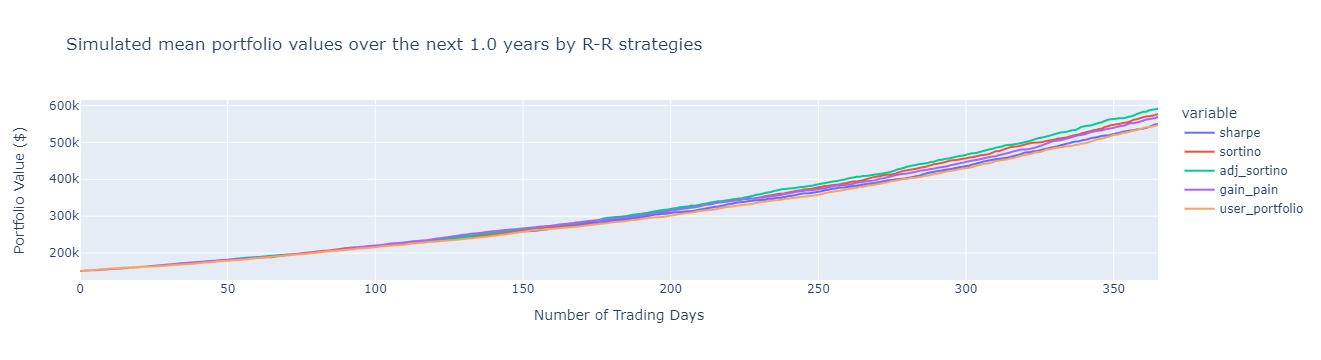

In [36]:
# Chart mean projection of each portfolio and store

sim_port_mean = px.line(
    all_mean_cumulative_pnl,
    title = f"Simulated mean portfolio values over the next {num_trading_days / 365} years by R-R strategies",
    labels = {
        "value": "Portfolio Value ($)",
        "index": "Number of Trading Days"
        
    }
)

sim_port_mean.show()

## Dashboard - Visualisations of Portfolio Weightages and Recommendations 

In [37]:
#FIRST PAGE  - what was done, how
title = "# Portfolio Analysis"
welcome_text = "### The following charts show the historical performance and risk-reward metrics of assets in your portfolio. Recommended weightages are also represented, along with the historical performance of portfolios recommneded by our risk-reward strategies, and a forecast of returns for each." 
first_page = pn.Column(title, welcome_text)

#SECOND PAGE - returns of tickers
daily_returns = round(daily_returns, 2)
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumul_plot = px.line(cumulative_returns, x = cumulative_returns.index, y = cumulative_returns.columns, title = "Cumulative Returns of Tickers")
daily_returns_plot = px.line(daily_returns, x = daily_returns.index, y = daily_returns.columns, title = "Daily Returns of Tickers")
boxplot = px.box(daily_returns, y=daily_returns.columns, title = 'Risk of Tickers')

second_page = pn.Column("## Ticker Analysis", daily_returns.head(), daily_returns_plot, cumulative_returns.head(), cumul_plot)

#THIRD PAGE (if) - og port analysis
if portfolio_choice ==1:
    pie_og = px.pie(pie_df, values=value_list, names=ticker_list, title="Distribution of existing portfolio", color_discrete_sequence=px.colors.sequential.RdBu)
    third_page = pn.Column("## Original Portfolio Analysis", weight_og, pie_og, portfolio_og.head(), daily_returns_port, cumul_plot_port, boxplot)
        
#Fourth Page
if portfolio_choice == 1:
    fourth_page = pn.Column(
        "## Recommended Weights in Comparison to Original Portfolio",  
        weight_og, pie_og, weights, 
        pn.Row(sharpe_pie, sortino_pie),
        pn.Row(adj_sortino_pie, pain_gain_pie)
    )
else:
    fourth_page = pn.Column("## Recommended Weights for Portfolio", weights, 
                            pn.Row(sharpe_pie, sortino_pie),
                            pn.Row(adj_sortino_pie, pain_gain_pie)
                           )
        
#Fifth Page
port_cumulative_returns = (1 + port_returns).cumprod() - 1
port_cumul_plot = px.line(port_cumulative_returns, x = port_cumulative_returns.index, y = port_cumulative_returns.columns, title = "Cumulative Returns of Tickers")
port_returns_plot = px.line(port_returns, x = port_returns.index, y = port_returns.columns, title = "Daily Returns of Portfolio")
port_boxplot = px.box(port_returns, y=port_returns.columns, title = 'Risk of Portfolio')

fifth_page = pn.Column(
    "## Portfolio Analysis",
    "### Portfolio Returns",
    port_returns.head(), port_returns_plot,
    "### Portfolio Cumulative Returns",
    port_cumulative_returns.head(), port_cumul_plot,
    "### Visualised Risk of Each Portfolio",
    port_boxplot)

#sixth
ann_std = port_returns.std() * np.sqrt(252)
# Calculate rolling standard deviation
r21_std = port_returns.rolling(window=21).std()
r21_std_plot = px.line(r21_std, x = r21_std.index, y = r21_std.columns, title = "Rolling-21 Day Std")

correlation = port_returns.corr()
corr_plot = px.imshow(correlation)

sixth_page = pn.Column(
    "## Annual Standard Deviation", 
    ann_std, r21_std_plot, 
    "## Correlation of portfolios", correlation, corr_plot, 
    "## Portfolio Close", portfolio_close_df.tail(), 
    "## Portfolio Returns", port_returns_df.tail()
)

seventh_page = pn.Column(
    "# Autoregression modelling", 
    interact[1], interact[0],
    "# Monte Carlo Simulation:",
    "## Simulated Returns", simulated_returns.tail(), 
    "## Mean Cumulative PNL", all_mean_cumulative_pnl.tail(), sim_port_mean
)

if portfolio_choice == 1:
    final_dashboard = pn.Tabs(
        ("Welcome", first_page),
        ("Crypto Daily and Cumulative Returns", second_page),
        ("Risk-Reward", third_page),
        ("Recommended Weights", fourth_page),
        ("Comparing Portfolios", fifth_page),
        ("Comparing Portfolios" , sixth_page),
        ("Forecasting" , seventh_page)
    )
elif portfolio_choice == 2:
    final_dashboard = pn.Tabs(
        ("Welcome", first_page),
        ("Ticker Analysis", second_page),
        ("Recommended Weights", fourth_page),
        ("Comparing Portfolios", fifth_page),
        ("Comparing Portfolios" , sixth_page),
        ("Forecasting" , seventh_page)
    )


# Display Dashboard
final_dashboard.show()
    



Launching server at http://localhost:54672
